# **Pipeline de dados do Telegram na AWS**

[Lucas V. B. Fontes](https://www.linkedin.com/in/lucas-vbfontes/)

You can find an english version of this project [here](http://) (WIP).

Esse projeto faz parte da grade do curso Analista de Dados da [EBAC](https://ebaconline.com.br/), representando um trabalho final e a consolidação dos conhecimentos adquiridos durante as aulas.


# **1. Contexto**

**TL;DR:** O projeto consiste em capturar mensagens enviadas em um grupo do Telegram, através de um chatbot, processá-las e apresentá-las em um banco de dados na nuvem.

## **1.1 Chatbots**

Chatbots são robôs utilizados em aplicativos de troca de mensagens ou aplicações de chat embutidas em home pages e/ou sites de empresas.

Através do uso de chatbots, além de automatizar tarefas repetitivas de atendimento que um humano faria, abre-se uma cartela de possibilidades para automação e melhoria desse tipo de serviço.

Por exemplo, realizando a captura das mensagens, uma determinada empresa pode:
- medir se o fluxo de mensagens está bem definido
- entender em quais períodos o bot é mais acionado
- analisar frequência de assuntos nos atendimentos automatizados

## **1.2 Resumo do Projeto**

Implementaremos uma **pipeline** de dados com camadas de ingestão, ETL (*extract, transform, load*) e apresentação das mensagens extraídas, utilizando *Python* e ferramentas da nuvem da *Amazon*.

Ao final do processo, teremos um banco de dados populado de forma automatizada, onde conseguiremos extrair métricas e realizar as análises.

# **2. Arquitetura**

Abaixo apresento um diagrama demonstrando a arquitetura utilizada no projeto:

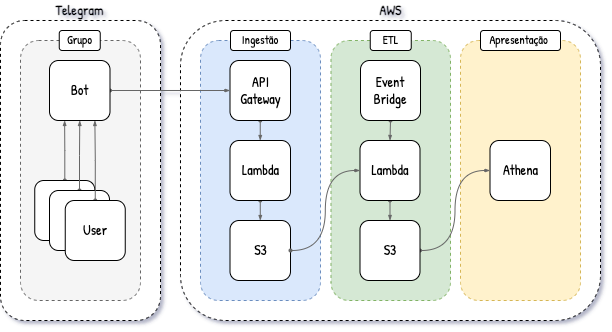

## **2.1 Sistema Transacional**

O ambiente transacional representa a origem dos dados, no caso desse projeto a representação desse sistema é o Telegram, contemplando o chatbot e suas configurações.

Através da adição do bot em um grupo, conseguimos configurar a API de bots do Telegram para realizar a captura das mensagens. 

## **2.2 Sistema Analítico**

Essa camada será representada pela Amazon Web Services (AWS), onde realizaremos as transformações e análises do dado transacional (agora transformado em analítico).

### **2.2.1 Ingestão**

A camada de ingestão é responsável por ingerir os dados transacionais para ambientes analíticos, sendo comum armazená-los com o minímo de processamento possível.

A ingestão pode ser realizada de duas formas, dependendo da aplicabilidade: 
- via *batch* (extração em lotes, seguindo um intervalo fixo de tempo) 
- via *streaming* (o dado é ingerido conforme é produzido).

As mensagens capturadas pelo bot ficam disponíveis nos servidores do Telegram durante 24 horas, e podem ser consumidas através da API de bots.
Por esse motivo, decidimos realizar a ingestão via *streaming*.

Utilizando o serviço da AWS API Gateway, configuramos um webhook para redirecionamento dos dados da API do Telegram.
Fazemos então a captura dessas mensagens e armazenamos em seu formato original (JSON) em um bucket do S3.

Os passos seguidos nessa etapa foram os seguintes:

- Criação um *bucket* no `AWS S3`;
- Criação de uma função no `AWS Lambda`;
- Criação uma API *web* no `AWS API Gateway`;
- Configuração de *webhook* da API de *bots* do **Telegram** (código na [seção 3](#3.1_fonte)). 

#### **AWS S3 Bucket Raw**

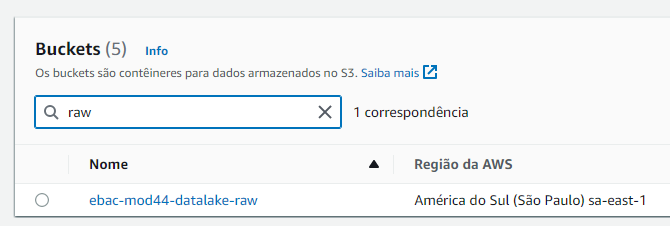

#### **Código utilizado no AWS Lambda (1)**

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve, 
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')
  
  try:

    message = json.loads(event["body"])
    # message = event
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

#### **AWS API Gateway**

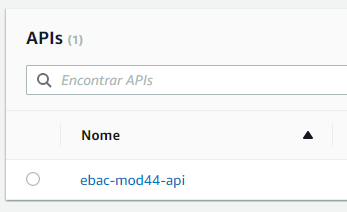

### **2.2.2 ETL**

A etapa de extração, transformação e carregamento (traduzido do inglês *extract, transform, load*) é uma camada abrangente, e seus processos podem variar dependendo da empresa, volumes e tipos de dados.

Em geral, o dado extraído pode passar por processos recorrentes de transformação (*data wrangling*), limpeza e agrupamento, e é persistido usando técnicas de particionamento, estando assim pronto para ser utilizado por profissinais da área de dados.

Na camada de ETL, as mensagens cruas de um único dia (D-1) armazenadas no bucket S3 serão manipuladas através de uma função do AWS Lambda, e compactadas em um arquivo orientado a coluna, passando também por alguns processos de data wrangling e enriquecimento.

Por fim, esses novos arquivos serão armazenados em um novo bucket, para posterior utilização na camada de apresentação.

Os passos seguidos nessa etapa foram os seguintes:

- Criação de um *bucket* no `AWS S3`;
- Criação de uma função no `AWS Lambda`;
- Configuração de um *scheduler* no `AWS Event Bridge`. 

#### **AWS S3 Bucket Enriched**

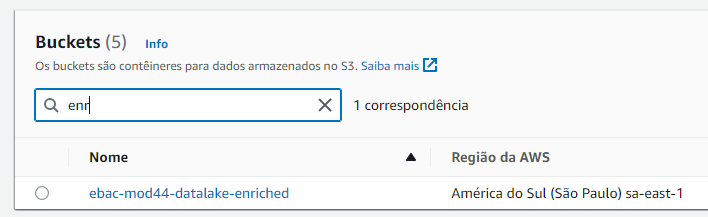

#### **Código utilizado no AWS Lambda (2)**

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único 
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None
          
      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True
  
  except Exception as exc:
      logging.error(msg=exc)
      return False
      
      
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

#### **AWS EventBridge**

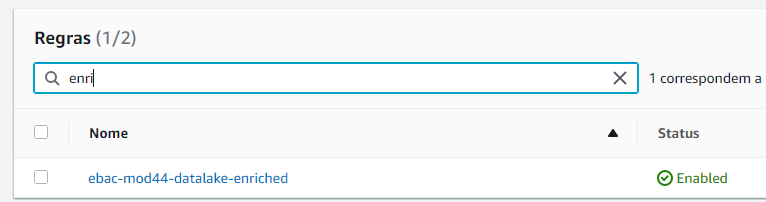

### **2.2.3 Apresentação**

Na etapa de apresentação, o dado é entregue para os usuários (analistas/cientistas de dados) e sistemas (dashboards, motores de consultas) "finais", normalmente através de uma interface de fácil de uso (como o SQL), sendo então a única etapa onde a maior parte dos usuários terá acesso.

Por conta disso, é importante que nessa etapa o dado seja entregue em camadas refinadas, tornando as consultas/consumos mais baratos. 

Para o nosso projeto, nessa etapa utilizaremos o AWS Athena, motor de consultas SQL em que podemos ler e apresentar os dados armazenados na camada de ETL.

Como passo adicional sugerido pela grade do curso, criei um processo adicional de automação da atualização do banco de dados com os arquivos compactados processados pela camada de ETL, evitando a necessidade de atualização através do AWS Athena (MSCK REPAIR TABLE). 

Os passos seguidos nessa etapa foram os seguintes:

- Criação de um banco de dados no `AWS Athena`;
- Criação de uma função no `AWS Lambda`;
- Configuração de um *scheduler* no `AWS Event Bridge`. 

#### **AWS Athena**

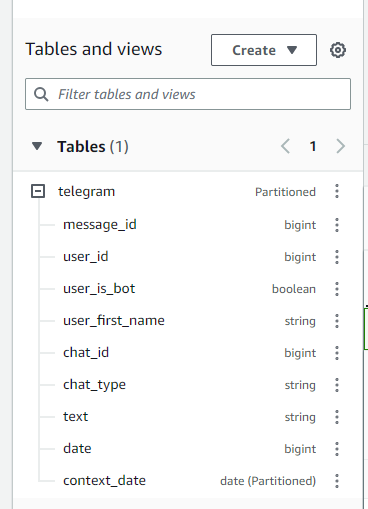

#### **Código utilizado no AWS Lambda (3)**

In [ ]:
import boto3
import os

def lambda_handler(event, context) -> bool:

    ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']
    
    client = boto3.client('athena')
    
    config = {
        'OutputLocation': 's3://' + ENRICHED_BUCKET,
        'EncryptionConfiguration': {'EncryptionOption': 'SSE_S3'}
    }
    
    # Query Execution Parameters
    sql = 'MSCK REPAIR TABLE default.telegram'
    context = {'Database': 'default'}
    
    client.start_query_execution(QueryString = sql, 
                                 QueryExecutionContext = context,
                                 ResultConfiguration = config)

    return True


#### **AWS EventBridge**

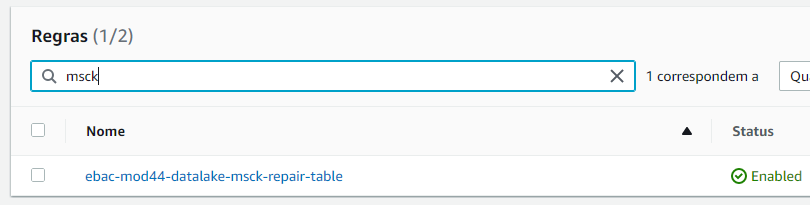

# **3. Análise Exploratória de Dados**

## **3.1 Fonte**

Analisando os dados produzidos pela API do Telegram, através do método `getUpdates`.

In [2]:
from getpass import getpass

token = getpass()

 ··············································


In [3]:
import json

base_url = f'https://api.telegram.org/bot{token}'

In [6]:
import requests

response = requests.get(url=f'{base_url}/getMe')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "id": 5612971051,
    "is_bot": true,
    "first_name": "ebac_m43_lucas_bot",
    "username": "ebac_m43_lucas_bot",
    "can_join_groups": false,
    "can_read_all_group_messages": false,
    "supports_inline_queries": false
  }
}


In [7]:
aws_api_gateway_url = getpass()

 ··························································


In [8]:
response = requests.get(url=f'{base_url}/deleteWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": true,
  "description": "Webhook was deleted"
}


In [10]:
response = requests.get(url=f'{base_url}/getUpdates')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": [
    {
      "update_id": 827758172,
      "message": {
        "message_id": 53,
        "from": {
          "id": 805844806,
          "is_bot": false,
          "first_name": "Lucas",
          "last_name": "Vieira Barboza Fontes",
          "username": "lvbfontes",
          "language_code": "pt-br"
        },
        "chat": {
          "id": -1001781281158,
          "title": "ebac_m43",
          "type": "supergroup"
        },
        "date": 1670535598,
        "text": "What is SQL? SQL stands for Structured Query Language. SQL lets you access and manipulate databases. SQL became a standard of the American National Standards Institute (ANSI) in 1986, and of the International Organization for Standardization (ISO) in 1987."
      }
    }
  ]
}


In [12]:
%%writefile telegram.json
{
  "ok": true,
  "result": [
    {
      "update_id": 827758172,
      "message": {
        "message_id": 53,
        "from": {
          "id": 805844806,
          "is_bot": false,
          "first_name": "Lucas",
          "last_name": "Vieira Barboza Fontes",
          "username": "lvbfontes",
          "language_code": "pt-br"
        },
        "chat": {
          "id": -1001781281158,
          "title": "ebac_m43",
          "type": "supergroup"
        },
        "date": 1670535598,
        "text": "What is SQL? SQL stands for Structured Query Language. SQL lets you access and manipulate databases. SQL became a standard of the American National Standards Institute (ANSI) in 1986, and of the International Organization for Standardization (ISO) in 1987."
      }
    }
  ]
}

Writing telegram.json


| chave | tipo valor | opcional | descrição |
| -- | -- | -- | -- |
| updated_id | int | não | id da mensagem enviada ao **bot** |
| message_id | int | não | id da mensagem enviada ao grupo |
| from_id | int | sim | id do usuário que enviou a mensagem |
| from_is_bot | bool | sim | se o usuário que enviou a mensagem é um **bot** |
| from_first_name | str | sim | primeiro nome do usário que enviou a mensagem |
| chat_id | int | não | id do *chat* em que a mensagem foi enviada |
| chat_type | str | não | tipo do *chat*: private, group, supergroup ou channel |
| date | int | não | data de envio da mensagem no formato unix |
| text | str | sim | texto da mensagem |

In [11]:
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": true,
  "description": "Webhook was set"
}


## **3.1 Destino**

Analisando o dado após a etapa de apresentação, através de consultas SQL.

# **4. Melhorias**

- [x] **Infraestrutura**

A tabela do AWS Athena não contem atualização automática de novas partiçoes. Adicionar essa funcionalidade no AWS Lambda.

- [ ] **Dados**

No projeto, estamos transformando e apresentando apenas os dados referentes a
mensagens de texto. Contudo, estamos ingerindo todas as mensagens que são enviadas
ao grupo do Telegram: vídeo, áudio, arquivos, etc. Uma melhoria seria adicionar novos
campos na função do AWS Lambda da etapa de ETL e na tabela do AWS Athena da
etapa de ingestão, ou ainda criar uma novas funções de ETL e tabelas de apresentação.

- [x] **Consultas**

A tabela do AWS Athena da camada de apresentação contém dados que apresentam
diversas oportunidades de criação de novas consultas analíticas. Uma melhoria seria a
criação de novas consultas SQL.